# Начало

## Ряд

            Unnamed: 0  target_price
dt                                  
2018-01-01           0       35600.0
2018-01-08           1       35600.0
2018-01-15           2       35300.0
2018-01-22           3       34500.0
2018-01-29           4       33700.0


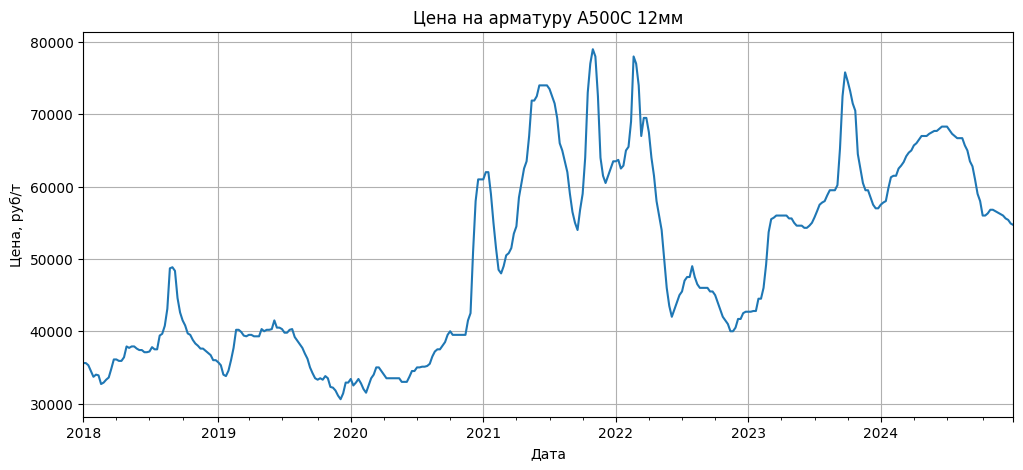

In [103]:
import pandas as pd
import matplotlib.pyplot as plt

df_price = pd.read_csv("./data/reinforcement_prices.csv")
df_price['dt'] = pd.to_datetime(df_price['dt'])
df_price = df_price.set_index('dt').sort_index()
df_price = df_price.rename(columns={"price_reinforcement_a500c_12mm_fca_Moscow": "target_price"})

print(df_price.head())

df_price['target_price'].plot(figsize=(12, 5), title="Цена на арматуру A500C 12мм")
plt.ylabel("Цена, руб/т")
plt.xlabel("Дата")
plt.grid(True)
plt.show()

## all_prices features

In [104]:
df_quotes = pd.read_csv("./data/reinforcement_all_prices.csv")


In [105]:

df_quotes['value_date'] = pd.to_datetime(df_quotes['value_date'])
fill_values = [
    'Cырье_концентрат_коксующегося_угля1',
    'Cырье_концентрат_коксующегося_угля2',
    'Cырье_концентрат_коксующегося_угля3',
    'Cырье_концентрат_коксующегося_угля4'
]
nan_indices = df_quotes[df_quotes['basis'].isna()].index

for i, idx in enumerate(nan_indices):
    df_quotes.loc[idx, 'basis'] = fill_values[i % len(fill_values)]

df_quotes = df_quotes[['basis', 'value_date',  'value']]
df_quotes_wide = df_quotes.pivot_table(index='value_date', columns='basis', values='value').sort_index()

убираем, где дофига пропущено

In [106]:
target = df_quotes_wide["Арматура, А500С 12мм, FCA склад трейдера Москва, руб./т, с НДС"].copy()
df_quotes_wide = df_quotes_wide.rename(columns={"Арматура, А500С 12мм, FCA склад трейдера Москва, руб./т, с НДС" : "target"})
# df_quotes_wide.drop("Арматура, А500С 12мм, FCA склад трейдера Москва, руб./т, с НДС", axis=1, inplace=True)

missing_values = df_quotes_wide.isna().sum()
threshold = 0.3
df_wide_clean = df_quotes_wide.loc[:, missing_values / len(df_quotes_wide) < threshold]
df_wide_clean = df_wide_clean.drop(columns=df_wide_clean.columns[df_wide_clean.iloc[-1].isna()])
df_wide_clean = df_wide_clean.drop(columns=df_wide_clean.columns[df_wide_clean.iloc[0].isna()])

остальные линейно интерполируем

In [107]:

df_wide_clean = df_wide_clean.interpolate(method='linear', limit_direction='both')

In [108]:
df = df_wide_clean
df.to_csv('test1.csv')

формируем фичадатасет из котировок. используем лаги за 2 месяца, также вычисляем абсолютную и относительную разницу между лагами

In [109]:
from warnings import simplefilter
simplefilter(action="ignore", category=pd.errors.PerformanceWarning)
newdf = pd.DataFrame()
colnames = list(df.columns)
for col in colnames:
    # create lags for prev 2 months
    for i in range(1,9):
        newdf[f'{col}_shift_{i}'] = df[col].shift(i)

    # abs diff between lags
    for i in range(1, 8):
        newdf[f'{col}_diff_abs_{i}_{i+1}'] = newdf[f'{col}_shift_{i}'] - newdf[f'{col}_shift_{i+1}']

    # relative diff
    for i in range(1, 8):
        newdf[f'{col}_diff_rel_{i}_{i+1}'] = (
            (newdf[f'{col}_shift_{i}'] - newdf[f'{col}_shift_{i+1}']) /
            (newdf[f'{col}_shift_{i+1}'] + 1e-10)
        )


присоединяем target

In [110]:

newdf['target'] = target
df = newdf
df = df.dropna()
import gc
gc.collect()

23514

## Добавляем данных

In [111]:
from pandas.tseries.offsets import MonthEnd
pd.options.mode.chained_assignment = None


def create_wide_df(df, colname, suffix, value_date='value_date', value='value'):
    df[value_date] = pd.to_datetime(df[value_date])
    var = df[[colname, value_date, value]]
    wide = df.pivot_table(index=value_date, columns=colname,values=value,aggfunc='mean').sort_index()
    wide = wide.add_suffix(suffix)

    return wide

def add_cols(df1,df2,days):
    for idx in df1.index:
        target_date = idx - pd.Timedelta(days=days)
        mask = df2.index + MonthEnd(1) <= target_date
        if mask.any():
            closest_date = df2.index[mask].max()
            for col in df2.columns:
                df1.loc[idx, col] = df2.loc[closest_date, col]

def add_cols_enhanced_with_shift(df1, df2, days, n_lags=2):
    df2_with_lags = df2.copy()
    df2_with_lags = df2_with_lags.add_suffix('_m_0')

    for i in range(1, n_lags+1):
        for col in df2.columns:
            df2_with_lags[f'{col}_m_{i}'] = df2[col].shift(i)

    for i in range(n_lags):
        for col in df2.columns:
            df2_with_lags[f'{col}_abs_diff_m_{i+1}'] = (
                df2_with_lags[f'{col}_m_{i}'] if i == 0 else df2_with_lags[f'{col}_m_{i-1}']
            ) - df2_with_lags[f'{col}_m_{i+1}']

            denominator = df2_with_lags[f'{col}_m_{i+1}'].replace(0, 1e-10)
            df2_with_lags[f'{col}_rel_diff_m_{i+1}'] = (
                ((df2_with_lags[f'{col}_m_{i}'] if i == 0 else df2_with_lags[f'{col}_m_{i-1}'])
                 - df2_with_lags[f'{col}_m_{i+1}']) / denominator
            )

    for idx in df1.index:
        target_date = idx - pd.Timedelta(days=days)
        mask = df2_with_lags.index + MonthEnd(1) <= target_date

        if mask.any():
            closest_date = df2_with_lags.index[mask].max()

            for col in df2_with_lags.columns:
                df1.loc[idx, col] = df2_with_lags.loc[closest_date, col]

    return df1

### Production

In [112]:
df_prod = pd.read_csv('./data/reinforcement_production.csv')
df_prod.head(3)

,country,manufacturer,product,subproduct,value_date,category,value
0,Россия,Лебединский ГОК,Металлизованная продукция,ГБЖ,2018-01-01,Сырье,425.0
1,Россия,Оскольский ЭМК,Металлизованная продукция,ПВЖ,2018-01-01,Сырье,286.0
2,Россия,Белон,Рядовой коксующийся уголь,Жирные,2018-01-01,Сырье,159.0


In [113]:
df_prod_wide1 = create_wide_df(df_prod, 'product', '_production_prev_month')
df_prod_wide2 = create_wide_df(df_prod, 'subproduct', '_production_prev_month')


In [114]:
df = add_cols_enhanced_with_shift(df, df_prod_wide1, days=35, n_lags=2)
df = add_cols_enhanced_with_shift(df, df_prod_wide2, days=35, n_lags=2)

### Consumption

In [115]:
df_cons = pd.read_csv('./data/reinforcement_consumption.csv')
df_cons.head(3)

,product,subproduct,value_date,category,subcategory,value,dt
0,Концентрат,NaN,2021-07-01,Россия->Сырье,ЖРС,3780.0,2021-07-01
1,Агломерат,NaN,2021-07-01,Россия->Сырье,ЖРС,334.0,2021-07-01
2,Окатыши,NaN,2021-07-01,Россия->Сырье,ЖРС,2969.0,2021-07-01


In [116]:
df_cons_wide1 = create_wide_df(df_cons, 'product', '_consumption')
df_cons_wide2 = create_wide_df(df_cons, 'subcategory', '_consumption')
df_cons_wide3 = create_wide_df(df_cons, 'category', '_consumption')

Добавлять ли их? выглядит как-то не очень, есть большой пропуск в части данных за более ранние года.

In [117]:
df_cons_wide1 = df_cons_wide1.dropna(axis=1)
df_cons_wide2 = df_cons_wide2.dropna(axis=1)

In [118]:
df = add_cols_enhanced_with_shift(df, df_cons_wide1, days=35, n_lags=2)
df = add_cols_enhanced_with_shift(df, df_cons_wide2, days=35, n_lags=2)

### Domestic supplies

In [119]:
df_domestic = pd.read_csv('./data/reinforcement_domestic_supplies.csv')
df_domestic.head(3)


,product,subproduct,value_date,category,value,supplier_customer,consumer_supplier
0,ЖРС,Концентрат,2018-01-01,Потребители->Казахстан->Сырье,150.0,АрселорМиттал Темиртау,Соколовско-Сарбайское ГПО
1,ЖРС,Окатыши,2018-01-01,Потребители->Казахстан->Сырье,95.0,АрселорМиттал Темиртау,Соколовско-Сарбайское ГПО
2,ЖРС,Агломерат,2018-01-01,Потребители->Украина->Сырье,379.0,Азовсталь,Мариупольский МК им. Ильича


In [120]:
df_domestic_wide1 = create_wide_df(df_domestic, 'product', '_domestic')
df_domestic_wide2 = create_wide_df(df_domestic, 'subproduct', '_domestic')
df_domestic_wide3 = create_wide_df(df_domestic, 'category', '_domestic')

Такой же вопрос, многих данных как будто бы нет...

In [121]:
df_domestic_wide1 = df_domestic_wide1.dropna(axis=1)
df_domestic_wide3 = df_domestic_wide3.dropna(axis=1)

In [122]:
df = add_cols_enhanced_with_shift(df, df_domestic_wide1, days=30, n_lags=2)
df = add_cols_enhanced_with_shift(df, df_domestic_wide2, days=30, n_lags=2)


### CIS export

In [123]:
df_import = pd.read_csv('./data/reinforcement_cis_import.csv')
df_import.head(3)

,country,supplier_customer,product,subproduct,value_date,category,value,dt
0,Казахстан,ЕВРАЗ-ЗСМК,ЖРС,Концентрат,2018-01-01,Импорт->Россия->Сырье,0.0,2018-01-01
1,Казахстан,Магнитогорский МК,ЖРС,Концентрат,2018-01-01,Импорт->Россия->Сырье,415.0,2018-01-01
2,Казахстан,Новолипецкий МК,ЖРС,Концентрат,2018-01-01,Импорт->Россия->Сырье,0.0,2018-01-01


In [124]:
df_import_wide1 = create_wide_df(df_import, 'country', '_import') # имеет смысл добавить только ближайшие Беларусь, Украину, Китай
# add_cols(df, df_import_wide1[['Беларусь_import', 'Казахстан_import', 'Китай_import']], 30)
df_import_wide2 = create_wide_df(df_import, 'product', '_import')
df_import_wide3 = create_wide_df(df_import, 'category', '_import')


In [125]:
df_import_wide2 = df_import_wide2.dropna(axis=1)
df_import_wide1 = df_import_wide1[['Беларусь_import', 'Казахстан_import', 'Китай_import']]

In [126]:
df = add_cols_enhanced_with_shift(df, df_import_wide1, days=30, n_lags=2)
df = add_cols_enhanced_with_shift(df, df_import_wide2, days=30, n_lags=2)


### Export

In [127]:
df_export = pd.read_csv('./data/reinforcement_cis_export.csv')
df_export = df_export[df_export['value_date'] != '2025-01-01']
df_export.head(3)

,country,supplier_customer,product,subproduct,value_date,category,value
0,Не определено,Лебединский ГОК,Металлизованная продукция,Всего отгружено с предприятия,2018-01-01,Экспорт->Россия->Сырье,333.0
1,Нидерланды,Лебединский ГОК,Металлизованная продукция,ГБЖ,2018-01-01,Экспорт->Россия->Сырье,0.0
2,Беларусь,Лебединский ГОК,Металлизованная продукция,ГБЖ,2018-01-01,Экспорт->Россия->Сырье,20.0


In [128]:
df_export_wide1 = create_wide_df(df_export, 'country', '_export')
df_export_wide2 = create_wide_df(df_export, 'product', '_export')
df_export_wide3 = create_wide_df(df_export, 'subproduct', '_export')

In [129]:
df_export_wide1 = df_export_wide1.dropna(axis=1).drop(columns=df_export_wide1.columns[(df_export_wide1 == 0).all()])
df_export_wide2 = df_export_wide2.dropna(axis=1).drop(columns=df_export_wide1.columns[(df_export_wide1 == 0).all()])
df_export_wide3 = df_export_wide3.dropna(axis=1).drop(columns=df_export_wide1.columns[(df_export_wide1 == 0).all()])

In [130]:
df = add_cols_enhanced_with_shift(df, df_export_wide2, days=30, n_lags=2)
df = add_cols_enhanced_with_shift(df, df_export_wide3, days=30, n_lags=2)


In [131]:
df.to_csv('./data/test.csv')

In [132]:
df = df.dropna(axis=1)

In [133]:
gc.collect()

0

In [134]:
df

,"3А, FOB РФ Черное море, $/т_shift_1","3А, FOB РФ Черное море, $/т_shift_2","3А, FOB РФ Черное море, $/т_shift_3","3А, FOB РФ Черное море, $/т_shift_4","3А, FOB РФ Черное море, $/т_shift_5","3А, FOB РФ Черное море, $/т_shift_6","3А, FOB РФ Черное море, $/т_shift_7","3А, FOB РФ Черное море, $/т_shift_8","3А, FOB РФ Черное море, $/т_diff_abs_1_2","3А, FOB РФ Черное море, $/т_diff_abs_2_3",...,"Украинский концентрат Fe 65-68%, DAP граница Украины с Европой, $/т_diff_abs_6_7","Украинский концентрат Fe 65-68%, DAP граница Украины с Европой, $/т_diff_abs_7_8","Украинский концентрат Fe 65-68%, DAP граница Украины с Европой, $/т_diff_rel_1_2","Украинский концентрат Fe 65-68%, DAP граница Украины с Европой, $/т_diff_rel_2_3","Украинский концентрат Fe 65-68%, DAP граница Украины с Европой, $/т_diff_rel_3_4","Украинский концентрат Fe 65-68%, DAP граница Украины с Европой, $/т_diff_rel_4_5","Украинский концентрат Fe 65-68%, DAP граница Украины с Европой, $/т_diff_rel_5_6","Украинский концентрат Fe 65-68%, DAP граница Украины с Европой, $/т_diff_rel_6_7","Украинский концентрат Fe 65-68%, DAP граница Украины с Европой, $/т_diff_rel_7_8",target
value_date,,,,,,,,,,,,,,,,,,,,,
2018-02-26,305.0,303.0,300.0,300.0,312.0,317.0,325.0,320.0,2.0,3.0,...,0.0,0.0,0.000000,0.000000,0.000000,0.038961,0.000000,0.000000,0.000000,32900.0
2018-03-05,315.0,305.0,303.0,300.0,300.0,312.0,317.0,325.0,10.0,2.0,...,0.0,0.0,-0.075000,0.000000,0.000000,0.000000,0.038961,0.000000,0.000000,33300.0
2018-03-12,325.0,315.0,305.0,303.0,300.0,300.0,312.0,317.0,10.0,10.0,...,3.0,0.0,0.000000,-0.075000,0.000000,0.000000,0.000000,0.038961,0.000000,33600.0
2018-03-19,325.0,325.0,315.0,305.0,303.0,300.0,300.0,312.0,0.0,10.0,...,0.0,3.0,0.000000,0.000000,-0.075000,0.000000,0.000000,0.000000,0.038961,34800.0
2018-03-26,323.0,325.0,325.0,315.0,305.0,303.0,300.0,300.0,-2.0,0.0,...,0.0,0.0,0.000000,0.000000,0.000000,-0.075000,0.000000,0.000000,0.000000,36100.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-02,276.0,283.0,295.0,299.0,297.0,304.0,309.0,321.0,-7.0,-12.0,...,0.0,0.0,0.000000,0.000000,0.000000,0.011236,0.000000,0.000000,0.000000,56000.0
2024-12-09,273.0,276.0,283.0,295.0,299.0,297.0,304.0,309.0,-3.0,-7.0,...,0.0,0.0,0.088889,0.000000,0.000000,0.000000,0.011236,0.000000,0.000000,55600.0
2024-12-16,279.0,273.0,276.0,283.0,295.0,299.0,297.0,304.0,6.0,-3.0,...,1.0,0.0,0.000000,0.088889,0.000000,0.000000,0.000000,0.011236,0.000000,55400.0


## Извлекаем самые полезные фичи

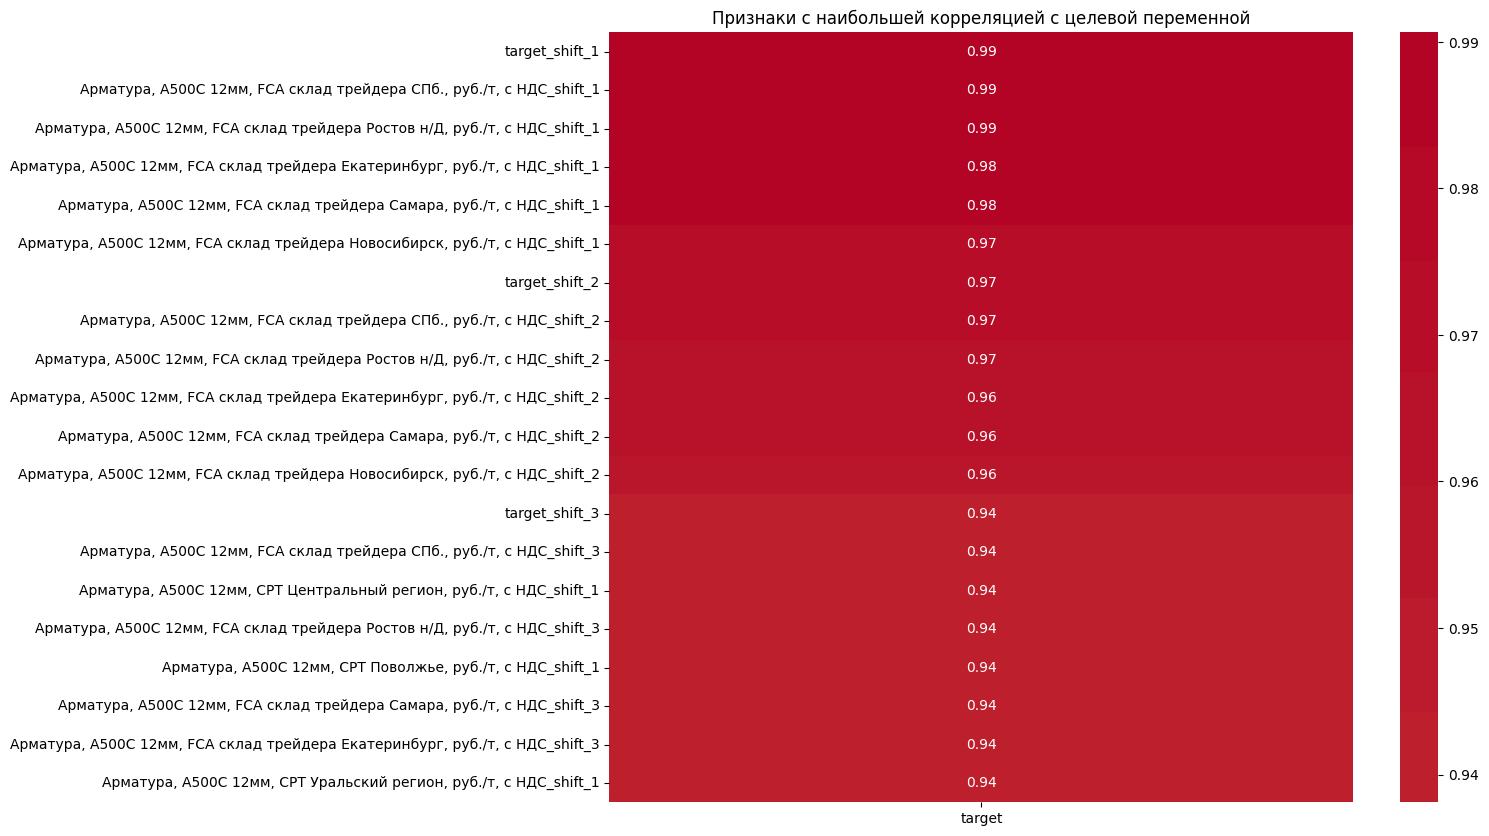

In [135]:
import seaborn as sns
import matplotlib.pyplot as plt

corr_matrix = df.corr()

top_features = corr_matrix['target'].abs().sort_values(ascending=False).index[1:21]

plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix.loc[top_features, ['target']].sort_values(by='target', ascending=False),
            annot=True, cmap='coolwarm', center=0)
plt.title('Признаки с наибольшей корреляцией с целевой переменной')
plt.show()

уберем сразу все, что меньше 0.20 по модулю (корреляция)

In [136]:
corr_threshold = 0.20
correlations = df.corr()['target'].abs()
selected_features = correlations[correlations > corr_threshold].index
df_filtered = df[selected_features]

In [137]:
df_filtered.describe()

,"3А, FOB РФ Черное море, $/т_shift_1","3А, FOB РФ Черное море, $/т_shift_2","3А, FOB РФ Черное море, $/т_shift_3","3А, FOB РФ Черное море, $/т_shift_4","3А, FOB РФ Черное море, $/т_shift_5","3А, FOB РФ Черное море, $/т_shift_6","3А, FOB РФ Черное море, $/т_shift_7","3А, FOB РФ Черное море, $/т_shift_8","3А, РФ CPT ж/д Сибирский ФО, руб./т, без НДС_shift_1","3А, РФ CPT ж/д Сибирский ФО, руб./т, без НДС_shift_2",...,"Украинские окатыши Fe 65-66%, DAP граница Украины с Европой, $/т_shift_8","Украинский концентрат Fe 65-68%, DAP граница Украины с Европой, $/т_shift_1","Украинский концентрат Fe 65-68%, DAP граница Украины с Европой, $/т_shift_2","Украинский концентрат Fe 65-68%, DAP граница Украины с Европой, $/т_shift_3","Украинский концентрат Fe 65-68%, DAP граница Украины с Европой, $/т_shift_4","Украинский концентрат Fe 65-68%, DAP граница Украины с Европой, $/т_shift_5","Украинский концентрат Fe 65-68%, DAP граница Украины с Европой, $/т_shift_6","Украинский концентрат Fe 65-68%, DAP граница Украины с Европой, $/т_shift_7","Украинский концентрат Fe 65-68%, DAP граница Украины с Европой, $/т_shift_8",target
count,358.000000,358.000000,358.000000,358.000000,358.000000,358.000000,358.000000,358.000000,358.000000,358.000000,...,358.000000,358.000000,358.000000,358.000000,358.000000,358.000000,358.000000,358.000000,358.000000,358.000000
mean,324.555866,324.608939,324.645251,324.703911,324.812849,324.927374,325.044693,325.114525,21493.047486,21469.759777,...,144.678771,107.631285,107.581006,107.530726,107.480447,107.421788,107.385475,107.349162,107.312849,49897.597765
std,74.255151,74.232869,74.217599,74.189715,74.142199,74.098241,74.064914,74.048290,5400.249858,5412.042229,...,36.009338,31.804609,31.834092,31.863468,31.892737,31.929514,31.956764,31.983949,32.011070,13080.027918
min,188.000000,188.000000,188.000000,188.000000,188.000000,188.000000,188.000000,188.000000,12149.000000,12149.000000,...,101.000000,72.000000,72.000000,72.000000,72.000000,72.000000,72.000000,72.000000,72.000000,30600.000000
25%,273.500000,273.500000,273.500000,273.500000,275.000000,275.000000,275.000000,275.000000,16426.000000,16356.500000,...,118.000000,86.000000,85.250000,85.000000,85.000000,85.000000,84.250000,84.000000,84.000000,37900.000000
50%,310.000000,310.000000,310.000000,310.000000,310.500000,311.000000,311.000000,311.000000,21602.000000,21517.000000,...,137.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,47500.000000
75%,361.000000,361.000000,361.000000,361.000000,361.000000,361.000000,361.000000,361.000000,26662.500000,26662.500000,...,157.750000,117.000000,117.000000,117.000000,117.000000,117.000000,117.000000,117.000000,117.000000,61000.000000
max,588.000000,588.000000,588.000000,588.000000,588.000000,588.000000,588.000000,588.000000,31137.000000,31137.000000,...,268.000000,218.000000,218.000000,218.000000,218.000000,218.000000,218.000000,218.000000,218.000000,79000.000000


# Решение

## RandomForestRegressor

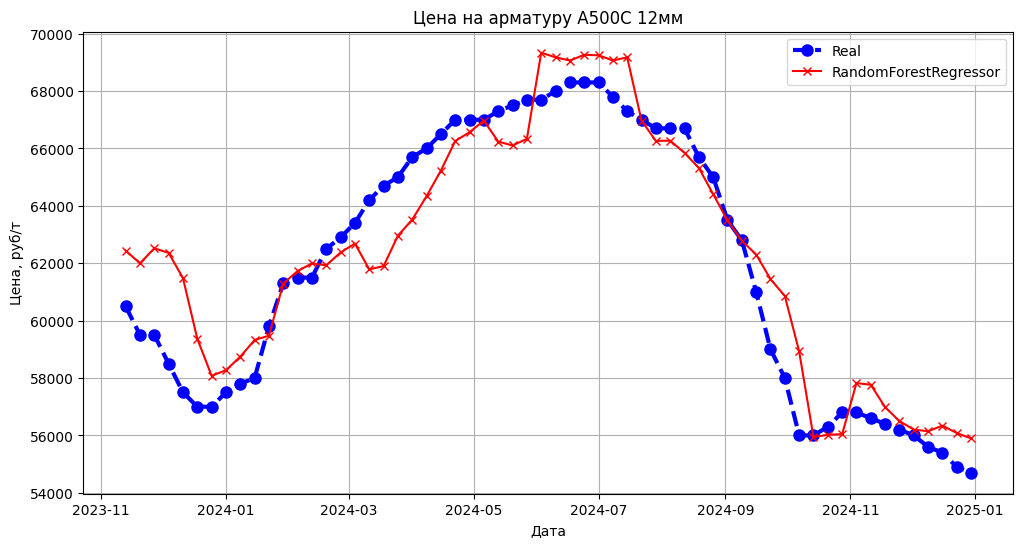

In [138]:
pred_size = 60
test = df.tail(pred_size)
train = df.iloc[:-pred_size]
X_train = train.drop(columns='target')
y_train = train['target']
X_test = test.drop(columns='target')
y_test = test['target']
model = RandomForestRegressor(n_estimators=189, max_depth=10, min_samples_split=2)
model.fit(X_train, y_train)
pred = model.predict(X_test)
plt.figure(figsize=(12, 6))
plt.plot(test.index, y_test, label='Real', color='blue', linestyle='--', marker='o', linewidth=3, markersize=8)
plt.plot(test.index, pred, label='RandomForestRegressor', color='red', linestyle='-', marker='x')
plt.ylabel("Цена, руб/т")
plt.xlabel("Дата")
plt.title("Цена на арматуру A500C 12мм")
plt.legend()
plt.grid(True)
plt.show()


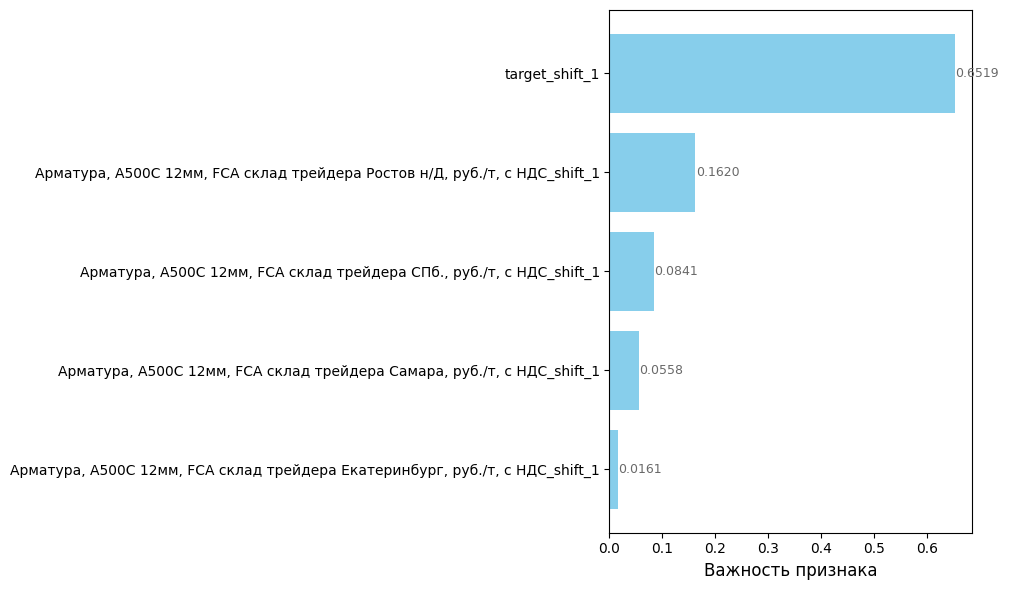

In [139]:
# Извлекаем важность признаков и их названия
importances = model.feature_importances_
feature_names = X_train.columns

# Сортируем и выбираем топ-10
sorted_idx = importances.argsort()[::-1][:5]  # Индексы топ-10 по убыванию
top_features = feature_names[sorted_idx]
top_importances = importances[sorted_idx]

# Создаем красивый график
plt.figure(figsize=(10, 6))
plt.barh(top_features, top_importances, color='skyblue')
plt.xlabel('Важность признака', fontsize=12)
plt.gca().invert_yaxis()  # Самый важный признак сверху

# Добавляем значения на бары
for i, v in enumerate(top_importances):
    plt.text(v + 0.001, i, f"{v:.4f}", color='dimgrey', va='center', fontsize=9)

plt.tight_layout()
plt.show()


## ARIMA

ADF Statistic (Исходный ряд): -1.863
p-value: 0.350
Критические значения:
   1%: -3.453
   5%: -2.871
   10%: -2.572
Ряд НЕстационарен (не отвергаем H0)


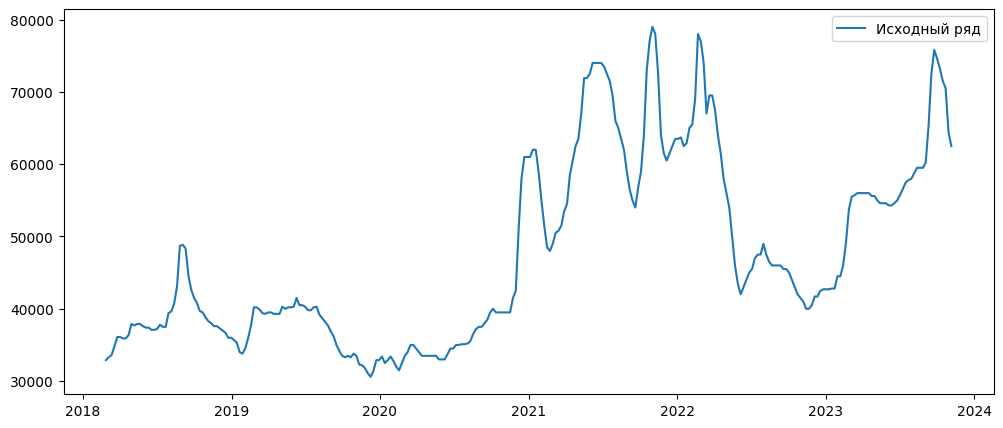

In [140]:
from statsmodels.tsa.stattools import adfuller

def test_stationarity(series, title=''):
    plt.figure(figsize=(12, 5))
    plt.plot(series, label=title)
    plt.legend()
    
    result = adfuller(series.dropna())
    print(f'ADF Statistic ({title}): {result[0]:.3f}')
    print(f'p-value: {result[1]:.3f}')
    print('Критические значения:')
    for k, v in result[4].items():
        print(f'   {k}: {v:.3f}')
    
    if result[1] < 0.05:
        print("Ряд стационарен (отвергаем H0)")
    else:
        print("Ряд НЕстационарен (не отвергаем H0)")
test_stationarity(y_train, 'Исходный ряд')

ADF Statistic (1-я разность): -7.586
p-value: 0.000
Критические значения:
   1%: -3.453
   5%: -2.871
   10%: -2.572
Ряд стационарен (отвергаем H0)


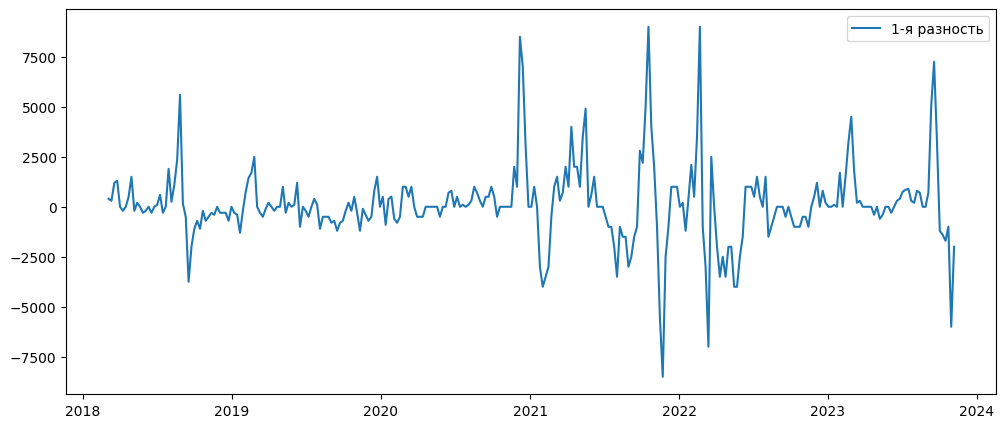

In [141]:
diff_1 = y_train.diff().dropna()
test_stationarity(diff_1, '1-я разность')
d = 1

ADF Statistic (1-я разность): -8.399
p-value: 0.000
Критические значения:
   1%: -3.454
   5%: -2.872
   10%: -2.572
Ряд стационарен (отвергаем H0)


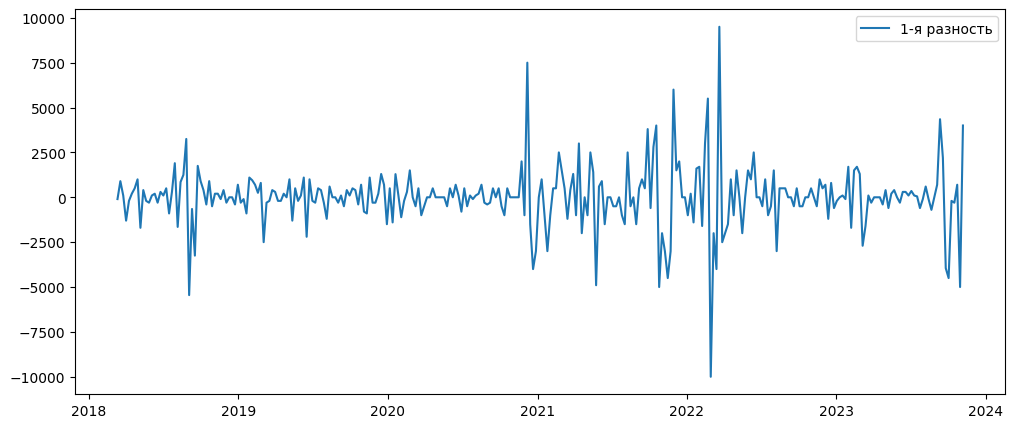

In [142]:
diff_2 = diff_1.diff().dropna()
test_stationarity(diff_2, '1-я разность')


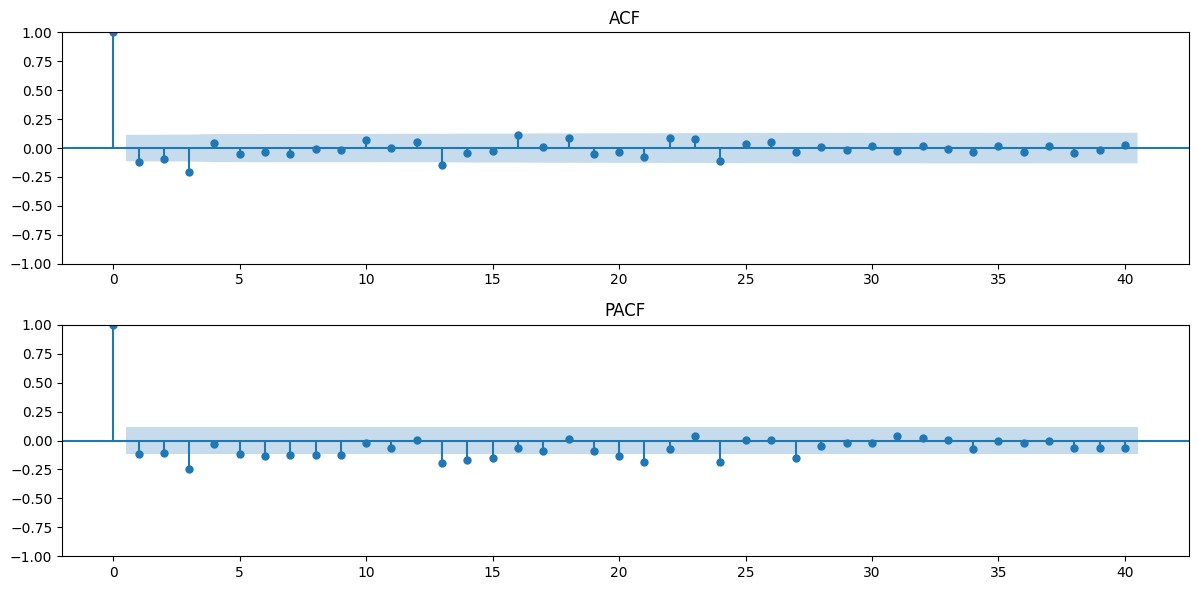

In [143]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plt.figure(figsize=(12, 6))
plt.subplot(211)
plot_acf(diff_2, lags=40, ax=plt.gca())
plt.title('ACF')

plt.subplot(212)
plot_pacf(diff_2, lags=40, ax=plt.gca(), method='ols')
plt.title('PACF')
plt.tight_layout()

/Users/snow0w/repos/ADD/24_25CourseWork/venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
/Users/snow0w/repos/ADD/24_25CourseWork/venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
/Users/snow0w/repos/ADD/24_25CourseWork/venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                 target   No. Observations:                  298
Model:                 ARIMA(2, 1, 2)   Log Likelihood               -2626.806
Date:                Sun, 22 Jun 2025   AIC                           5263.612
Time:                        06:40:08   BIC                           5282.080
Sample:                    02-26-2018   HQIC                          5271.005
                         - 11-06-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4053      0.335     -1.210      0.226      -1.062       0.251
ar.L2          0.1353      0.204      0.665      0.506      -0.264       0.534
ma.L1          0.8173      0.339      2.407      0.0

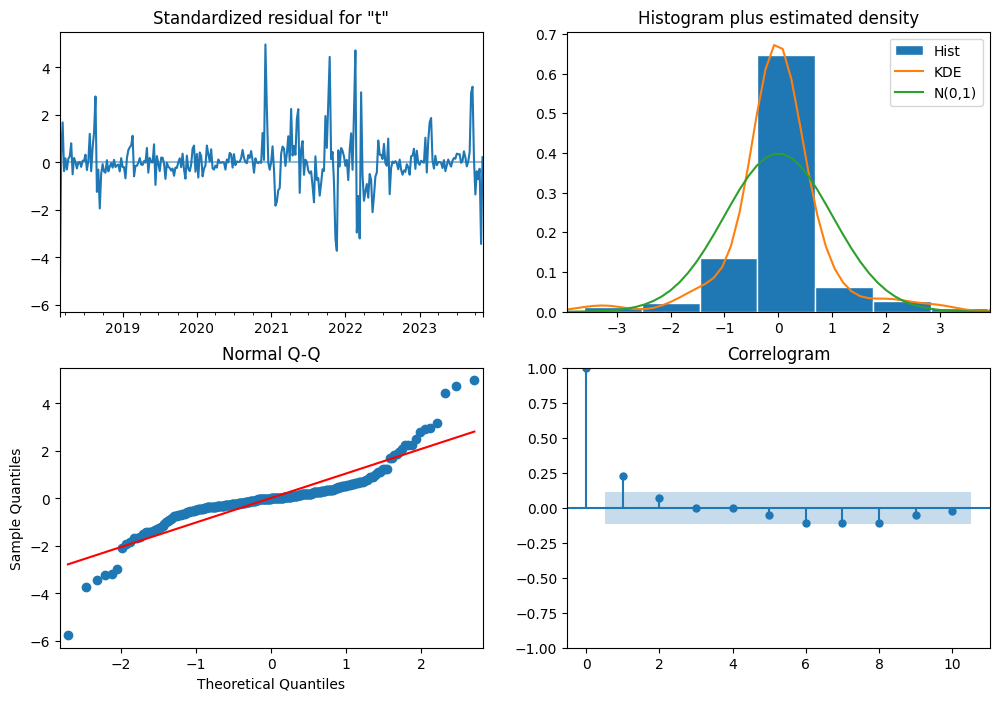

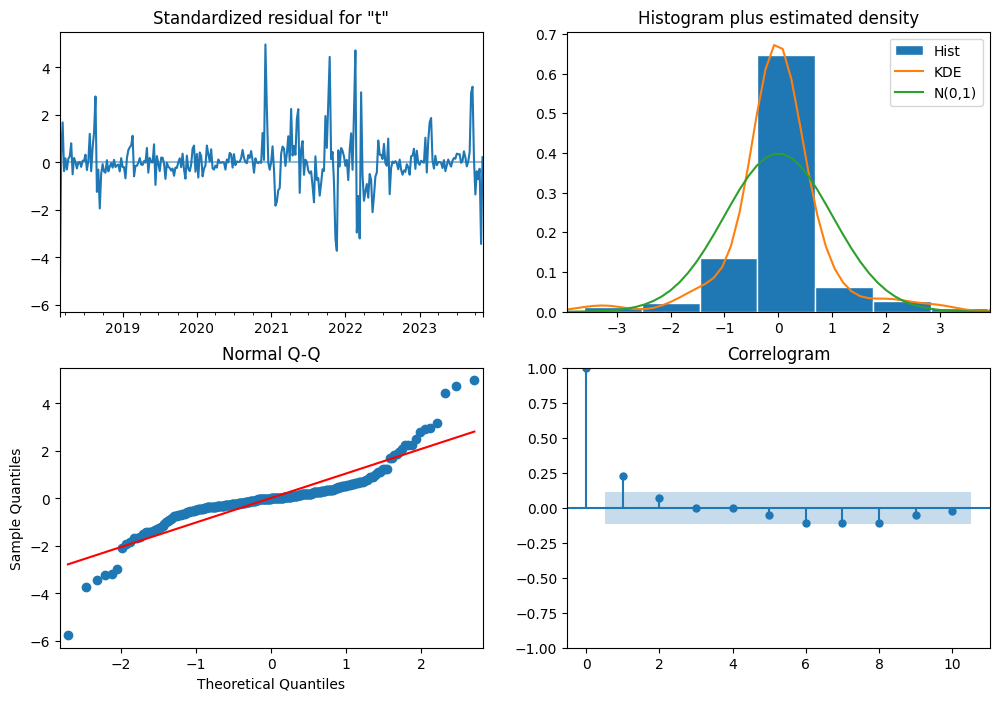

In [144]:
from statsmodels.tsa.arima.model import ARIMA

model = ARIMA(y_train, order=(2,1,2))  
results = model.fit()
print(results.summary())

results.plot_diagnostics(figsize=(12, 8))

In [145]:
import itertools

# Генерация всех возможных комбинаций p,d,q
p_range = range(0, 10)  # 0-2
d_range = range(1, 3)  # 0-1
q_range = range(0, 6)  # 0-2

best_aic = float('inf')
best_order = None

for p, d, q in itertools.product(p_range, d_range, q_range):
    try:
        model = ARIMA(y_train, order=(p,d,q))
        results = model.fit()
        if results.aic < best_aic:
            best_aic = results.aic
            best_order = (p,d,q)
    except:
        continue

print(f'Лучшая модель ARIMA{best_order} с AIC={best_aic:.2f}')

/Users/snow0w/repos/ADD/24_25CourseWork/venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
/Users/snow0w/repos/ADD/24_25CourseWork/venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
/Users/snow0w/repos/ADD/24_25CourseWork/venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
/Users/snow0w/repos/ADD/24_25CourseWork/venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
/Users/snow0w/repos/ADD/24_25CourseWork/

/Users/snow0w/repos/ADD/24_25CourseWork/venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
/Users/snow0w/repos/ADD/24_25CourseWork/venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
/Users/snow0w/repos/ADD/24_25CourseWork/venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
/Users/snow0w/repos/ADD/24_25CourseWork/venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
/Users/snow0w/repos/ADD/24_25CourseWork/

Лучшая модель ARIMA(5, 2, 1) с AIC=5203.94


/Users/snow0w/repos/ADD/24_25CourseWork/venv/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


/Users/snow0w/repos/ADD/24_25CourseWork/venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
/Users/snow0w/repos/ADD/24_25CourseWork/venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
/Users/snow0w/repos/ADD/24_25CourseWork/venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
/Users/snow0w/repos/ADD/24_25CourseWork/venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
/Users/snow0w/repos/ADD/24_25CourseWork/

/Users/snow0w/repos/ADD/24_25CourseWork/venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
/Users/snow0w/repos/ADD/24_25CourseWork/venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
/Users/snow0w/repos/ADD/24_25CourseWork/venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
/Users/snow0w/repos/ADD/24_25CourseWork/venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
/Users/snow0w/repos/ADD/24_25CourseWork/

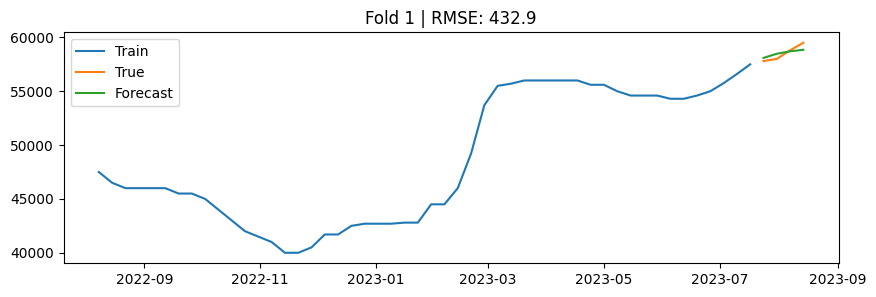

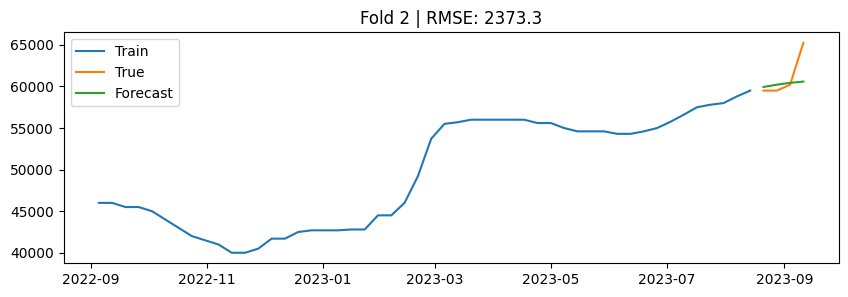

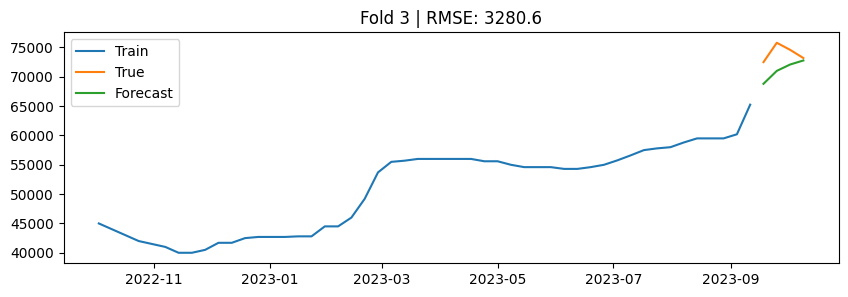

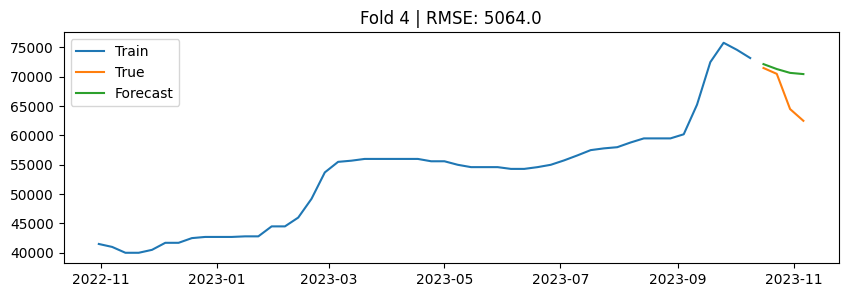

In [146]:
from sklearn.model_selection import TimeSeriesSplit

tscv = TimeSeriesSplit(
    n_splits=4,
    test_size=4,
    gap=0
)

for fold, (train_idx, test_idx) in enumerate(tscv.split(y_train), 1):
    train_ar, test_ar = y_train[train_idx], y_train[test_idx]
    model = ARIMA(train_ar, order=(5,2,1)).fit()
    forecast = model.forecast(steps=len(test_ar))
    
    plt.figure(figsize=(10, 3))
    plt.plot(train_ar.tail(50), label='Train')
    plt.plot(test_ar.index, test_ar, label='True')
    plt.plot(test_ar.index, forecast, label='Forecast')
    rmse = np.sqrt(np.mean((test_ar - forecast)**2))
    plt.title(f'Fold {fold} | RMSE: {rmse:.1f}')
    plt.legend()

## Optimal Strategy

In [147]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.linear_model import Lasso, Ridge

In [165]:
import optuna
from sklearn.model_selection import TimeSeriesSplit, cross_val_score

In [166]:
def objective(trial, model_name, X, y):
    if model_name == 'Random Forest':
        n_estimators = trial.suggest_int('n_estimators', 50, 300)
        max_depth = trial.suggest_int('max_depth', 3, 20)
        min_samples_split = trial.suggest_int('min_samples_split', 2, 10)
        model = RandomForestRegressor(
            n_estimators=n_estimators,
            max_depth=max_depth,
            min_samples_split=min_samples_split,
            random_state=42
        )
    elif model_name == 'XGBoost':
        n_estimators = trial.suggest_int('n_estimators', 50, 300)
        max_depth = trial.suggest_int('max_depth', 3, 15)
        learning_rate = trial.suggest_float('learning_rate', 0.01, 0.3)
        model = XGBRegressor(
            n_estimators=n_estimators,
            max_depth=max_depth,
            learning_rate=learning_rate,
            random_state=42,
            verbosity=0
        )
    elif model_name == 'Lasso':
        alpha = trial.suggest_float('alpha', 0.0001, 1.0, log=True)
        model = Lasso(alpha=alpha, random_state=42, max_iter=10000)
    # Ridge (если нужно)
    # elif model_name == 'Ridge':
    #     alpha = trial.suggest_float('alpha', 0.0001, 1.0, log=True)
    #     model = Ridge(alpha=alpha, random_state=42, max_iter=10000)
    else:
        raise ValueError("Unknown model")

    tscv = TimeSeriesSplit(n_splits=3)
    scores = cross_val_score(model, X, y, cv=tscv, scoring='neg_mean_absolute_error')
    return -scores.mean()


In [167]:
def tune_model(model_name, X, y, n_trials=30):
    study = optuna.create_study(direction='minimize', sampler=optuna.samplers.TPESampler(seed=42))
    func = lambda trial: objective(trial, model_name, X, y)
    study.optimize(func, n_trials=n_trials)
    print(f'Best params for {model_name}: {study.best_params}')
    return study.best_params


In [168]:
import warnings
warnings.filterwarnings('ignore')

# ARIMA
from statsmodels.tsa.arima.model import ARIMA

In [169]:
# Функции ошибок
def root_mean_squared_error(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def cross_val_mae_rmse(model, X, y, n_splits=5):
    tscv = TimeSeriesSplit(n_splits=n_splits)
    maes, rmses = [], []
    for train_idx, val_idx in tscv.split(X):
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
        model.fit(X_train, y_train)
        preds = model.predict(X_val)
        maes.append(mean_absolute_error(y_val, preds))
        rmses.append(root_mean_squared_error(y_val, preds))
    return np.mean(maes), np.mean(rmses)

from statsmodels.tsa.arima.model import ARIMA

# ARIMA rolling
def arima_predict_rolling(train, order=(5, 1, 0)):
    history = list(train)
    model = ARIMA(history, order=order)
    model_fit = model.fit()
    yhat = model_fit.forecast(steps=4)
    return np.array(yhat)

models = {
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
    'XGBoost': XGBRegressor(n_estimators=100, random_state=42),
    'Lasso': Lasso(alpha=0.1, random_state=42)
    # 'Ridge': Ridge(alpha=0.1)
}
colors = ['red', 'green', 'purple', 'orange', 'brown']  # Добавили extra color для ARIMA

In [184]:
import numpy as np
import pandas as pd

from sklearn.base import clone
from sklearn.base import clone

def calculate_predictions_for_month(df, pred_size, model_name, week, models):
    test = df.tail(pred_size - week)
    train = df.iloc[:-(pred_size - week)]
    X_train = train.drop(columns='target')
    y_train = train['target']
    X_test = test.drop(columns='target')
    y_test = test['target']

    if model_name == 'ARIMA':

        return arima_predict_rolling(y_train), y_test.head(4)

    model = clone(models[model_name])  # клонируем модель для изоляции
    model.fit(X_train, y_train)
    # return model.predict(X_train.head(4)), y_test.head(4)
    return model.predict(X_test.head(4)), y_test.head(4)

def simulate_procurement_strategy_advanced_cost_based(df, pred_size, model_name, max_horizon=4, min_horizon=1, models=None):
    n = pred_size
    week = 0
    total_cost_strategy = 0
    total_cost_real_by_strategy = 0
    #total_cost_real = 0
    procurement_log = []
    purchases_df_rows = []

    while week < n:
        y_pred, y_true = calculate_predictions_for_month(df, pred_size, model_name, week, models)
        base_price = y_pred[0]
        horizon = min_horizon

        for h in range(min_horizon, max_horizon):
            if h >= len(y_pred):
                break
            if y_pred[h] <= base_price:
                break
            horizon += 1


        buy_weeks = min(horizon, n - week)
        buy_price_pred = y_pred[0]
        buy_price_real = y_true.iloc[0]
        cost_strategy = buy_price_pred * buy_weeks
        cost_real_by_strategy = buy_price_real * buy_weeks
        real_cost = y_true.iloc[0:buy_weeks].sum()

        total_cost_strategy += cost_strategy
        total_cost_real_by_strategy += cost_real_by_strategy
        #total_cost_real += real_cost

        procurement_log.append({
            'start_week': week,
            'buy_weeks': buy_weeks,
            'buy_price_pred': buy_price_pred,
            'buy_price_real': buy_price_real,
            'cost_strategy': cost_strategy,
            'cost_real_by_strategy': cost_real_by_strategy,
            'real_cost': real_cost,
            'real_prices': list(y_true.iloc[0:buy_weeks].values),
            'cumulative_forecast_cost': np.sum(y_pred[0:buy_weeks])
        })

        for i in range(buy_weeks):
            purchases_df_rows.append({
                'Неделя': week + i,
                'Покупка': int(i == 0),
                'Горизонт_покупки': buy_weeks if i == 0 else 0,
                'Прогнозная_цена': buy_price_pred,
                'Прогнозная_цена_по_неделям': y_pred[i],
                'Реальная_цена_закупки': buy_price_real if i == 0 else np.nan,
                'Реальная_цена_факт': y_true.iloc[i]
            })

        week += buy_weeks

    procurement_log_df = pd.DataFrame(procurement_log)
    purchases_df = pd.DataFrame(purchases_df_rows)

    return total_cost_strategy, total_cost_real_by_strategy, None, procurement_log_df, purchases_df

In [185]:
# Основная функция
def train_and_test(df, models, colors, pred_size):
    test = df.tail(pred_size)
    train = df.iloc[:-pred_size]
    X_train = train.drop(columns='target')
    y_train = train['target']
    X_test = test.drop(columns='target')
    y_test = test['target']
    predictions = {}

    # ==== Hyperparameter tuning ====
    best_params = {}
    for name in models.keys():
        print(f"\nПодбор гиперпараметров для {name}...")
        best_params[name] = tune_model(name, X_train, y_train, n_trials=30)

    optimized_models = {
        'Random Forest': RandomForestRegressor(**best_params['Random Forest'], random_state=42),
        'XGBoost': XGBRegressor(**best_params['XGBoost'], random_state=42, verbosity=0),
        # 'Lasso': Lasso(**best_params['Lasso'], random_state=42, max_iter=10000)
        'Lasso': Lasso(random_state=42, max_iter=10000)
    }

    print("Cross-validation results (TimeSeriesSplit):")
    for name, model in optimized_models.items():
        mae_cv, rmse_cv = cross_val_mae_rmse(model, X_train, y_train)
        print(f"{name} CV -> MAE: {mae_cv:.2f}, RMSE: {rmse_cv:.2f}")

    for name, model in optimized_models.items():
        model.fit(X_train, y_train)
        pred = model.predict(X_test)
        predictions[name] = pred
        mae = mean_absolute_error(y_test, pred)
        rmse = root_mean_squared_error(y_test, pred)
        print(f"{name} -> MAE: {mae:.2f}, RMSE: {rmse:.2f}")

    # Вычисление общего эталонного cost
    #true_prices = df['target'].tail(pred_size).values
    #total_cost_real = np.sum(true_prices)

    total_cost_real_once = df['target'].tail(pred_size).sum()


    names = list(optimized_models.keys())
    names.append('ARIMA')
    print("\n=== Результаты сложной закупочной стратегии ===")
# Внутри train_and_test
    total_costs = {}  # для сохранения индивидуальных результатов

    for name in names:
        total_cost_strategy, total_cost_real_by_strategy, total_cost_real, procurement_log_df, purchases_df = simulate_procurement_strategy_advanced_cost_based(
            df, pred_size, name, models=optimized_models)

        total_costs[name] = {
            'strategy': total_cost_strategy,
            'real_by_strategy': total_cost_real_by_strategy,
            'real': total_cost_real_once
        }

        print(f"\n{name} (СЛОЖНАЯ СТРАТЕГИЯ):")
        #print(f"  - Затраты по стратегии закупки (по прогнозной цене): {total_costs[name]['strategy']:.2f} руб.")
        # print((purchases_df['Реальная_цена_факт'] * purchases_df['Покупка'] * purchases_df['Горизонт_покупки']).fillna(0.0).astype(float).sum())
        # print(f"  - Затраты по стратегии закупки (по реальной цене в момент закупки): {total_costs[name]['real_by_strategy']:.2f} руб.")
        # print(f"  - Затраты при покупке каждую неделю по факту (идеальный вариант): {total_costs[name]['real']:.2f} руб.")
        # print(f"  - Экономия/потери стратегии (реальная цена закупки): {total_costs[name]['real'] - total_costs[name]['real_by_strategy']:.2f} руб.")
        # print("  - Детализация закупок по стратегии:")

        display_df = procurement_log_df.copy()
        display_df['real_prices'] = display_df['real_prices'].apply(lambda x: ', '.join(f'{v:.2f}' for v in x))
        print(display_df[['start_week', 'buy_weeks', 'buy_price_pred', 'buy_price_real',
                          'cost_strategy', 'cost_real_by_strategy', 'real_cost', 'real_prices']].rename(
            columns={
                'start_week':'Неделя',
                'buy_weeks':'Горизонт_покупки',
                'buy_price_pred':'Прогнозная_цена',
                'buy_price_real':'Реальная_цена_закупки',
                'cost_strategy':'Затраты_по_стратегии',
                'cost_real_by_strategy':'Затраты_по_реальной_цене_закупки',
                'real_cost':'Факт_затраты',
                'real_prices':'Факт_цены_по_горизонту'
            }
        ).to_string(index=False))

        print("\n  - Выгрузка по неделям (для анализа):")
        purchases_df = purchases_df[['Неделя', 'Покупка', 'Горизонт_покупки', 'Прогнозная_цена','Прогнозная_цена_по_неделям', 'Реальная_цена_закупки']]
        purchases_df['Расход_по_прогнозной_цене'] = (purchases_df['Прогнозная_цена'] * purchases_df['Покупка'] * purchases_df['Горизонт_покупки']).fillna(0.0).astype(float)
        purchases_df['Расход_по_реальной_цене'] = (purchases_df['Реальная_цена_закупки'] * purchases_df['Покупка'] * purchases_df['Горизонт_покупки']).fillna(0.0).astype(float)
        purchases_df['Накопленный_расход_по_прогнозной_цене'] = purchases_df['Расход_по_прогнозной_цене'].cumsum()
        purchases_df['Накопленный_расход_по_реальной_цене'] = purchases_df['Расход_по_реальной_цене'].cumsum()

        cols = [
            'Неделя', 'Покупка', 'Горизонт_покупки', 'Прогнозная_цена','Прогнозная_цена_по_неделям', 'Реальная_цена_закупки',
            'Накопленный_расход_по_прогнозной_цене', 'Накопленный_расход_по_реальной_цене'
        ]
        result_df = purchases_df[cols]
        print(result_df.to_string(index=False))
        result_df.to_csv(f'result_df_{name}.csv', index=False)

    # Plot
    # plt.figure(figsize=(12, 6))
    # plt.plot(test.index, y_test, label='Real', color='blue', linestyle='--', marker='o', linewidth=3, markersize=8)
    # all_models = list(optimized_models.keys())  #+ ['ARIMA']
    # print(predictions)
    # # all_models.append('ARIMA')
    # for i, model in enumerate(all_models):
    #     plt.plot(test.index, predictions[model], label=model, color=colors[i], linestyle='-', marker='x')
    # plt.ylabel("Цена, руб/т")
    # plt.xlabel("Дата")
    # plt.title("Цена на арматуру A500C 12мм")
    # plt.legend()
    # plt.grid(True)
    # plt.show()

In [186]:
df_filtered = df_filtered.dropna()

In [187]:
train_and_test(df_filtered, models, colors, 60)

[I 2025-06-22 07:16:49,120] A new study created in memory with name: no-name-dccde3f5-c119-482b-a2a0-8c2689c99d81



Подбор гиперпараметров для Random Forest...


[I 2025-06-22 07:16:51,959] Trial 0 finished with value: 4723.768601328853 and parameters: {'n_estimators': 144, 'max_depth': 20, 'min_samples_split': 8}. Best is trial 0 with value: 4723.768601328853.
[I 2025-06-22 07:16:55,385] Trial 1 finished with value: 4130.028269616704 and parameters: {'n_estimators': 200, 'max_depth': 5, 'min_samples_split': 3}. Best is trial 1 with value: 4130.028269616704.
[I 2025-06-22 07:16:56,710] Trial 2 finished with value: 4620.795025228619 and parameters: {'n_estimators': 64, 'max_depth': 18, 'min_samples_split': 7}. Best is trial 1 with value: 4130.028269616704.
[I 2025-06-22 07:16:59,280] Trial 3 finished with value: 4985.593709985159 and parameters: {'n_estimators': 227, 'max_depth': 3, 'min_samples_split': 10}. Best is trial 1 with value: 4130.028269616704.
[I 2025-06-22 07:17:04,421] Trial 4 finished with value: 4156.070668867283 and parameters: {'n_estimators': 258, 'max_depth': 6, 'min_samples_split': 3}. Best is trial 1 with value: 4130.0282696

Best params for Random Forest: {'n_estimators': 189, 'max_depth': 10, 'min_samples_split': 2}

Подбор гиперпараметров для XGBoost...


[I 2025-06-22 07:18:53,055] Trial 0 finished with value: 3718.706257038288 and parameters: {'n_estimators': 144, 'max_depth': 15, 'learning_rate': 0.22227824312530747}. Best is trial 0 with value: 3718.706257038288.
[I 2025-06-22 07:18:54,726] Trial 1 finished with value: 3882.4452949042793 and parameters: {'n_estimators': 200, 'max_depth': 5, 'learning_rate': 0.055238410897498764}. Best is trial 0 with value: 3718.706257038288.
[I 2025-06-22 07:18:55,890] Trial 2 finished with value: 3624.9330130912163 and parameters: {'n_estimators': 64, 'max_depth': 14, 'learning_rate': 0.18432335340553055}. Best is trial 2 with value: 3624.9330130912163.
[I 2025-06-22 07:18:57,188] Trial 3 finished with value: 4145.51954884572 and parameters: {'n_estimators': 227, 'max_depth': 3, 'learning_rate': 0.29127385712697834}. Best is trial 2 with value: 3624.9330130912163.
[I 2025-06-22 07:18:59,244] Trial 4 finished with value: 3767.479043496622 and parameters: {'n_estimators': 258, 'max_depth': 5, 'learn

Best params for XGBoost: {'n_estimators': 108, 'max_depth': 7, 'learning_rate': 0.1695863475126348}

Подбор гиперпараметров для Lasso...


[I 2025-06-22 07:19:39,814] Trial 0 finished with value: 10422.900181781937 and parameters: {'alpha': 0.003148911647956862}. Best is trial 0 with value: 10422.900181781937.
[I 2025-06-22 07:19:40,580] Trial 1 finished with value: 10031.387028188808 and parameters: {'alpha': 0.6351221010640696}. Best is trial 1 with value: 10031.387028188808.
[I 2025-06-22 07:19:40,910] Trial 2 finished with value: 10426.483693991488 and parameters: {'alpha': 0.08471801418819976}. Best is trial 1 with value: 10031.387028188808.
[I 2025-06-22 07:19:41,225] Trial 3 finished with value: 10423.758267263538 and parameters: {'alpha': 0.024810409748678097}. Best is trial 1 with value: 10031.387028188808.
[I 2025-06-22 07:19:41,531] Trial 4 finished with value: 10422.79046746016 and parameters: {'alpha': 0.00042079886696066364}. Best is trial 1 with value: 10031.387028188808.
[I 2025-06-22 07:19:41,841] Trial 5 finished with value: 10422.790463702948 and parameters: {'alpha': 0.0004207053950287938}. Best is tri

Best params for Lasso: {'alpha': 0.9914675236878883}
Cross-validation results (TimeSeriesSplit):
Random Forest CV -> MAE: 3662.55, RMSE: 5098.45
XGBoost CV -> MAE: 3607.53, RMSE: 5111.48
Lasso CV -> MAE: 6534.42, RMSE: 7960.56
Random Forest -> MAE: 950.54, RMSE: 1277.34
XGBoost -> MAE: 1224.62, RMSE: 1590.59
Lasso -> MAE: 7629.14, RMSE: 8411.22

=== Результаты сложной закупочной стратегии ===

Random Forest (СЛОЖНАЯ СТРАТЕГИЯ):
 Неделя  Горизонт_покупки  Прогнозная_цена  Реальная_цена_закупки  Затраты_по_стратегии  Затраты_по_реальной_цене_закупки  Факт_затраты                 Факт_цены_по_горизонту
      0                 1     63103.502142                60500.0          63103.502142                           60500.0       60500.0                               60500.00
      1                 3     61276.870748                59500.0         183830.612245                          178500.0      177500.0           59500.00, 59500.00, 58500.00
      4                 1     58777.372134 

In [188]:
ar = []
ar.append(pd.read_csv('result_df_ARIMA.csv'))
ar.append(pd.read_csv('result_df_Lasso.csv'))
ar.append(pd.read_csv('result_df_Random Forest.csv'))
ar.append(pd.read_csv('result_df_XGBoost.csv'))

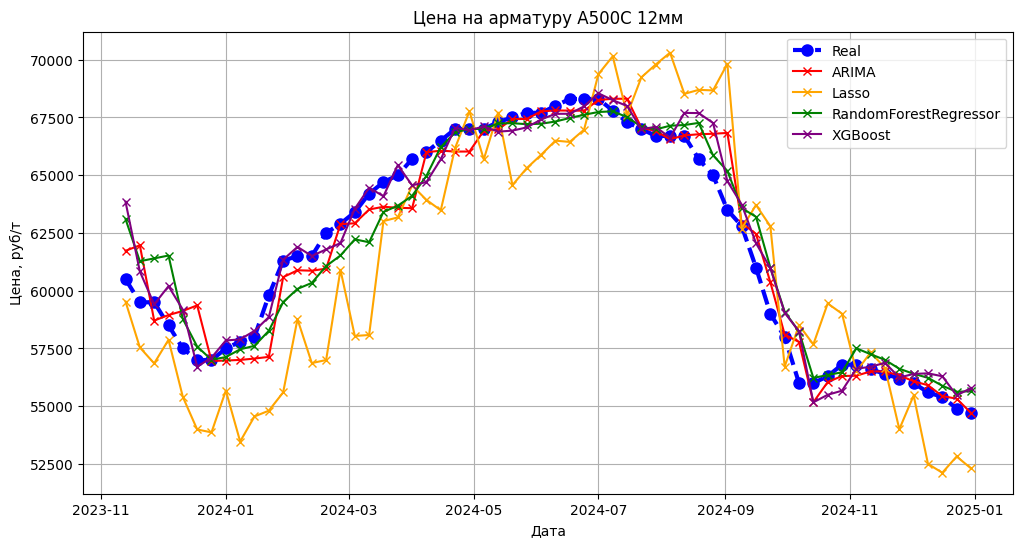

In [189]:
test = df.tail(60)
y_test = test['target']
names = ['ARIMA', 'Lasso', 'RandomForestRegressor', 'XGBoost']
colors = ['red', 'orange', 'green', 'purple']
# Plot
plt.figure(figsize=(12, 6))
plt.plot(test.index, y_test, label='Real', color='blue', linestyle='--', marker='o', linewidth=3, markersize=8)
for i, model in enumerate(ar):
    plt.plot(test.index, model['Прогнозная_цена_по_неделям'], label=names[i], color=colors[i], linestyle='-', marker='x')
# arima = ARIMA(y_train, order=(5,1,0))
# arima_fit = arima.fit()
# yhat = arima_fit.forecast(steps=60)
# plt.plot(test.index, yhat, label='Arima', color='orange', linestyle='-', marker='x')
plt.ylabel("Цена, руб/т")
plt.xlabel("Дата")
plt.title("Цена на арматуру A500C 12мм")
plt.legend()
plt.grid(True)
plt.show()

In [190]:
s = sum(y_test)
print(f'закупка каждую неделю: {s}')
for i, name in enumerate(names):
    p = (ar[i]['Реальная_цена_закупки'] * ar[i]['Горизонт_покупки']).fillna(0).sum()
    print(f'{name} стратегия - {p}')
    print(f'выгода на 1 тонну за 60 недель: {s - p}')
    print(f'относительная выгода на 1 тонну за 60 недель: {(s - p)/s:.4f}')
    print()

закупка каждую неделю: 3716800.0
ARIMA стратегия - 3716200.0
выгода на 1 тонну за 60 недель: 600.0
относительная выгода на 1 тонну за 60 недель: 0.0002

Lasso стратегия - 3722400.0
выгода на 1 тонну за 60 недель: -5600.0
относительная выгода на 1 тонну за 60 недель: -0.0015

RandomForestRegressor стратегия - 3702600.0
выгода на 1 тонну за 60 недель: 14200.0
относительная выгода на 1 тонну за 60 недель: 0.0038

XGBoost стратегия - 3704900.0
выгода на 1 тонну за 60 недель: 11900.0
относительная выгода на 1 тонну за 60 недель: 0.0032

